<center><img src='https://www.researchgate.net/profile/Hebert-Perez-Roses/publication/251573416/figure/fig1/AS:298122283634689@1448089299412/A-simple-flow-shop-scheduling-problem-with-3-jobs-and-3-machines.png' alt='saad-case'></center>
<br>
<center><h2>ANEXO I - JOB SHOP SCHEDULING vs. FLOW SHOP SEQUENCING</h2></center><br>

<p>Trabalho realizado no âmbito da disciplina de SAAD - Sistemas Analíticos de Apoio à Decisão, do mestrado em Engenharia e Ciência de Dados da Faculdade de Engenharia da Universidade do Porto (FEUP)</p>

<br>
Realizado por: 
<br>
<br>
<b>Danilo Brandão</b>
<br>
<b>Gabriel Carvalhal</b>
<br>
<b>Wagner Ceulin</b>

<center>Porto, 2022</center>

## DOWNLOADS NECESSÁRIOS

In [1]:
! pip install ortools
! pip install pyspark
! pip install pyschedule
! pip install clock
! pip install --upgrade passlib==1.7.2
! pip install passlib==1.7.2
! pip install mip
! pip install docplex
! pip install cplex
! pip install mip
! pip install gurobipy

#### BIBLIOTECAS UTILIZADAS

In [2]:
import pandas as pd
import numpy as np
import collections
from ortools.sat.python import cp_model
from itertools import compress #create a list
import os
os.chdir("C:/Users/ceuli/Desktop/saad_work/")

## 1.1 - CP SOLUTION: *Job Shop Scheduling Problem* 

Número de jobs: **15**<br>
Número de máquinas: **15** <br>
Time seed: **840612802**<br>
Machine seed: **398197754**<br>
Upper bound:**1231**<br>
Lower bound: **1005**<br>
<br>http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/jobshop.dir/tai15_15.txt

#### LEITURA DOS DADOS

In [3]:
import csv
with open("jobs.csv",encoding='utf-8-sig') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    jobs = [[tuple(map(int, row[i : i + 2])) for i in range(0, len(row), 2) ] for row in csv_reader ]
    print(jobs)

[[(7, 94), (13, 66), (5, 10), (8, 53), (4, 26), (3, 15), (11, 65), (12, 82), (9, 10), (15, 27), (10, 93), (14, 92), (6, 96), (1, 70), (2, 83)], [(5, 74), (6, 31), (8, 88), (15, 51), (14, 57), (9, 78), (12, 8), (10, 7), (7, 91), (11, 79), (1, 18), (4, 51), (13, 18), (2, 99), (3, 33)], [(2, 4), (9, 82), (10, 40), (13, 86), (7, 50), (12, 54), (14, 21), (6, 6), (1, 54), (3, 68), (8, 82), (11, 20), (5, 39), (4, 35), (15, 68)], [(6, 73), (3, 23), (10, 30), (7, 30), (11, 53), (1, 94), (14, 58), (5, 93), (8, 32), (15, 91), (12, 30), (9, 56), (13, 27), (2, 92), (4, 9)], [(8, 78), (9, 23), (7, 21), (11, 60), (5, 36), (10, 29), (3, 95), (15, 99), (13, 79), (6, 76), (2, 93), (14, 42), (12, 52), (1, 42), (4, 96)], [(6, 29), (4, 61), (13, 88), (14, 70), (12, 16), (5, 31), (15, 65), (8, 83), (3, 78), (2, 26), (11, 50), (1, 87), (10, 62), (7, 14), (9, 30)], [(13, 18), (4, 75), (8, 20), (9, 4), (15, 91), (7, 68), (2, 19), (12, 54), (5, 85), (6, 73), (3, 43), (11, 24), (1, 37), (14, 87), (10, 66)], [(12

#### DEFINIÇÃO DE PARÂMETROS

In [4]:
#Parametros
number_machines = 15
number_jobs = 15
time_seed = 840612802
machine_seed = 398197754      
upper_bound = 1231      
lower_bound = 1005

machines_count = 1 + max(task[0] for job in jobs for task in job)
all_machines = range(machines_count)
# Horizon é a somatória de todas as durações.
horizon = sum(task[1] for job in jobs for task in job)

In [5]:
machines_count

16

In [6]:
all_machines

range(0, 16)

In [7]:
horizon

11671

#### DECLARAÇÃO DO MODELO

In [8]:
model = cp_model.CpModel()

#### DEFINIÇÃO DE VARIÁVEIS

In [9]:
# Nomear em tuples para armazenar as informações.
task_type = collections.namedtuple('task_type', 'start end interval')
# Manipular as soluções em tuple.
assigned_task_type = collections.namedtuple('assigned_task_type',
                                            'start job index duration')


# Criar intervalos dos jobs e adicionar a lista de máquinas.
all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

for job_id, job in enumerate(jobs):
    for task_id, task in enumerate(job):
        machine = task[0]
        duration = task[1]
        suffix = '_%i_%i' % (job_id, task_id)
        start_var = model.NewIntVar(0, horizon, 'start' + suffix)
        end_var = model.NewIntVar(0, horizon, 'end' + suffix)
        interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                            'interval' + suffix)
        all_tasks[job_id, task_id] = task_type(start=start_var,
                                               end=end_var,
                                               interval=interval_var)
        machine_to_intervals[machine].append(interval_var)

#### DEFINIR CONSTRAINTS

In [10]:
# Criar e  and add disjunctive constraints.
for machine in all_machines:
    model.AddNoOverlap(machine_to_intervals[machine])

# Precedentes de um job.
for job_id, job in enumerate(jobs):
    for task_id in range(len(job) - 1):
        model.Add(all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end)

#### OBJETIVO DO MAKESPAN

In [11]:
obj_var = model.NewIntVar(0, horizon, 'makespan')
model.AddMaxEquality(obj_var, [
    all_tasks[job_id, len(job) - 1].end
    for job_id, job in enumerate(jobs)
])
model.Minimize(obj_var)

#### MODELO CP *Job Shop Scheduling Problem* 

In [12]:
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print('Solution:')
    # Criar uma lista de tasks por máquinas.
    assigned_jobs = collections.defaultdict(list)
    for job_id, job in enumerate(jobs):
        for task_id, task in enumerate(job):
            machine = task[0]
            assigned_jobs[machine].append(
                assigned_task_type(start=solver.Value(
                    all_tasks[job_id, task_id].start),
                                   job=job_id,
                                   index=task_id,
                                   duration=task[1]))

    # Criar um output por máquina.
    output = ''
    for machine in all_machines:
        # Ordenar por início.
        assigned_jobs[machine].sort()
        sol_line_tasks = 'Machine ' + str(machine) + ': '
        sol_line = '           '

        for assigned_task in assigned_jobs[machine]:
            name = 'j_%i_t_%i' % (assigned_task.job,
                                       assigned_task.index)
            # Adicionar espaço.
            sol_line_tasks += '%-15s' % name

            start = assigned_task.start
            duration = assigned_task.duration
            sol_tmp = '[%i,%i]' % (start, start + duration)
            # Add spaces to output to align columns.
            sol_line += '%-15s' % sol_tmp

        sol_line += '\n'
        sol_line_tasks += '\n'
        output += sol_line_tasks
        output += sol_line

    print(f'Optimal Schedule Length: {solver.ObjectiveValue()}')
    print(output)
else:
    print('No solution found.')

Solution:
Optimal Schedule Length: 1231.0
Machine 0: 
           
Machine 1: j_7_t_2        j_11_t_2       j_9_t_5        j_10_t_3       j_8_t_4        j_3_t_5        j_12_t_7       j_2_t_8        j_14_t_9       j_5_t_11       j_1_t_10       j_6_t_12       j_4_t_13       j_0_t_13       j_13_t_14      
           [84,93]        [93,168]       [222,239]      [262,270]      [313,326]      [326,420]      [572,649]      [804,858]      [858,866]      [866,953]      [962,980]      [986,1023]     [1030,1072]    [1078,1148]    [1195,1230]    
Machine 2: j_2_t_0        j_8_t_5        j_7_t_7        j_13_t_7       j_6_t_6        j_14_t_5       j_9_t_10       j_11_t_11      j_4_t_10       j_5_t_9        j_12_t_10      j_3_t_13       j_10_t_11      j_1_t_13       j_0_t_14       
           [0,4]          [326,413]      [413,475]      [478,534]      [534,553]      [553,579]      [583,652]      [652,697]      [697,790]      [790,816]      [816,864]      [864,956]      [956,1049]     [1049,1148]    [1

#### ESTATÍSTICAS

In [13]:
 # Statistics.
print('\nStatistics')
print('  - conflicts: %i' % solver.NumConflicts())
print('  - branches : %i' % solver.NumBranches())
print('  - wall time: %f s' % solver.WallTime())


Statistics
  - conflicts: 12329
  - branches : 15187
  - wall time: 10.368533 s


#### VISUALIZAÇÃO DOS DADOS

In [14]:
# Criar uma lista
row = []
for machine in all_machines:
# Ordenar o tempo inicial.
    assigned_jobs[machine].sort()
    sol_line_tasks = 'M'+str(machine)
    for assigned_task in assigned_jobs[machine]:
        name = 'j_%i_t_%i' % (assigned_task.job,assigned_task.index)
        row.append(sol_line_tasks) #machine
        row.append(assigned_task.job) #job
        row.append(assigned_task.index) #task
        row.append(assigned_task.start) #start
        row.append(assigned_task.duration) #duration
        sol_tmp = assigned_task.start + assigned_task.duration #star+duration
        row.append(sol_tmp) #star+duration
row

['M1',
 7,
 2,
 84,
 9,
 93,
 'M1',
 11,
 2,
 93,
 75,
 168,
 'M1',
 9,
 5,
 222,
 17,
 239,
 'M1',
 10,
 3,
 262,
 8,
 270,
 'M1',
 8,
 4,
 313,
 13,
 326,
 'M1',
 3,
 5,
 326,
 94,
 420,
 'M1',
 12,
 7,
 572,
 77,
 649,
 'M1',
 2,
 8,
 804,
 54,
 858,
 'M1',
 14,
 9,
 858,
 8,
 866,
 'M1',
 5,
 11,
 866,
 87,
 953,
 'M1',
 1,
 10,
 962,
 18,
 980,
 'M1',
 6,
 12,
 986,
 37,
 1023,
 'M1',
 4,
 13,
 1030,
 42,
 1072,
 'M1',
 0,
 13,
 1078,
 70,
 1148,
 'M1',
 13,
 14,
 1195,
 35,
 1230,
 'M2',
 2,
 0,
 0,
 4,
 4,
 'M2',
 8,
 5,
 326,
 87,
 413,
 'M2',
 7,
 7,
 413,
 62,
 475,
 'M2',
 13,
 7,
 478,
 56,
 534,
 'M2',
 6,
 6,
 534,
 19,
 553,
 'M2',
 14,
 5,
 553,
 26,
 579,
 'M2',
 9,
 10,
 583,
 69,
 652,
 'M2',
 11,
 11,
 652,
 45,
 697,
 'M2',
 4,
 10,
 697,
 93,
 790,
 'M2',
 5,
 9,
 790,
 26,
 816,
 'M2',
 12,
 10,
 816,
 48,
 864,
 'M2',
 3,
 13,
 864,
 92,
 956,
 'M2',
 10,
 11,
 956,
 93,
 1049,
 'M2',
 1,
 13,
 1049,
 99,
 1148,
 'M2',
 0,
 14,
 1148,
 83,
 1231,
 'M3',
 11,
 0,

In [15]:
#Visualizar nova lista
series = pd.Series(row)
df = list(series.values.reshape(225,6))
print(df)

[array(['M1', 7, 2, 84, 9, 93], dtype=object), array(['M1', 11, 2, 93, 75, 168], dtype=object), array(['M1', 9, 5, 222, 17, 239], dtype=object), array(['M1', 10, 3, 262, 8, 270], dtype=object), array(['M1', 8, 4, 313, 13, 326], dtype=object), array(['M1', 3, 5, 326, 94, 420], dtype=object), array(['M1', 12, 7, 572, 77, 649], dtype=object), array(['M1', 2, 8, 804, 54, 858], dtype=object), array(['M1', 14, 9, 858, 8, 866], dtype=object), array(['M1', 5, 11, 866, 87, 953], dtype=object), array(['M1', 1, 10, 962, 18, 980], dtype=object), array(['M1', 6, 12, 986, 37, 1023], dtype=object), array(['M1', 4, 13, 1030, 42, 1072], dtype=object), array(['M1', 0, 13, 1078, 70, 1148], dtype=object), array(['M1', 13, 14, 1195, 35, 1230], dtype=object), array(['M2', 2, 0, 0, 4, 4], dtype=object), array(['M2', 8, 5, 326, 87, 413], dtype=object), array(['M2', 7, 7, 413, 62, 475], dtype=object), array(['M2', 13, 7, 478, 56, 534], dtype=object), array(['M2', 6, 6, 534, 19, 553], dtype=object), array(['M2'

In [16]:
#Visualizar Data Frame
df = pd.DataFrame(df, columns=['Machine', 'job','task','start','duration','time'])
print(df)

    Machine  job  task  start  duration  time
0        M1    7     2     84         9    93
1        M1   11     2     93        75   168
2        M1    9     5    222        17   239
3        M1   10     3    262         8   270
4        M1    8     4    313        13   326
..      ...  ...   ...    ...       ...   ...
220     M15    0     9    753        27   780
221     M15   14     7    780        73   853
222     M15    9    12    955        82  1037
223     M15    2    14   1117        68  1185
224     M15   12    14   1185        44  1229

[225 rows x 6 columns]


In [17]:
schedule = pd.DataFrame(df)

print('\nSchedule by Job')
print(schedule.sort_values(by=['job','start']).set_index(['job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','start']).set_index(['Machine', 'job']))


Schedule by Job
             task  start  duration  time
job Machine                             
0   M7          0      5        94    99
    M13         1     99        66   165
    M5          2    215        10   225
    M8          3    225        53   278
    M4          4    278        26   304
...           ...    ...       ...   ...
14  M8         10    866        12   878
    M4         11    878        87   965
    M3         12    965        83  1048
    M10        13   1048        20  1068
    M6         14   1095        97  1192

[225 rows x 4 columns]

Schedule by Machine
             task  start  duration  time
Machine job                             
M1      7       2     84         9    93
        11      2     93        75   168
        9       5    222        17   239
        10      3    262         8   270
        8       4    313        13   326
...           ...    ...       ...   ...
M9      0       8    689        10   699
        1       5    699        78  

In [18]:
schedule

,Machine,job,task,start,duration,time
0,M1,7,2,84,9,93
1,M1,11,2,93,75,168
2,M1,9,5,222,17,239
3,M1,10,3,262,8,270
4,M1,8,4,313,13,326
...,...,...,...,...,...,...
220,M15,0,9,753,27,780
221,M15,14,7,780,73,853
222,M15,9,12,955,82,1037
223,M15,2,14,1117,68,1185


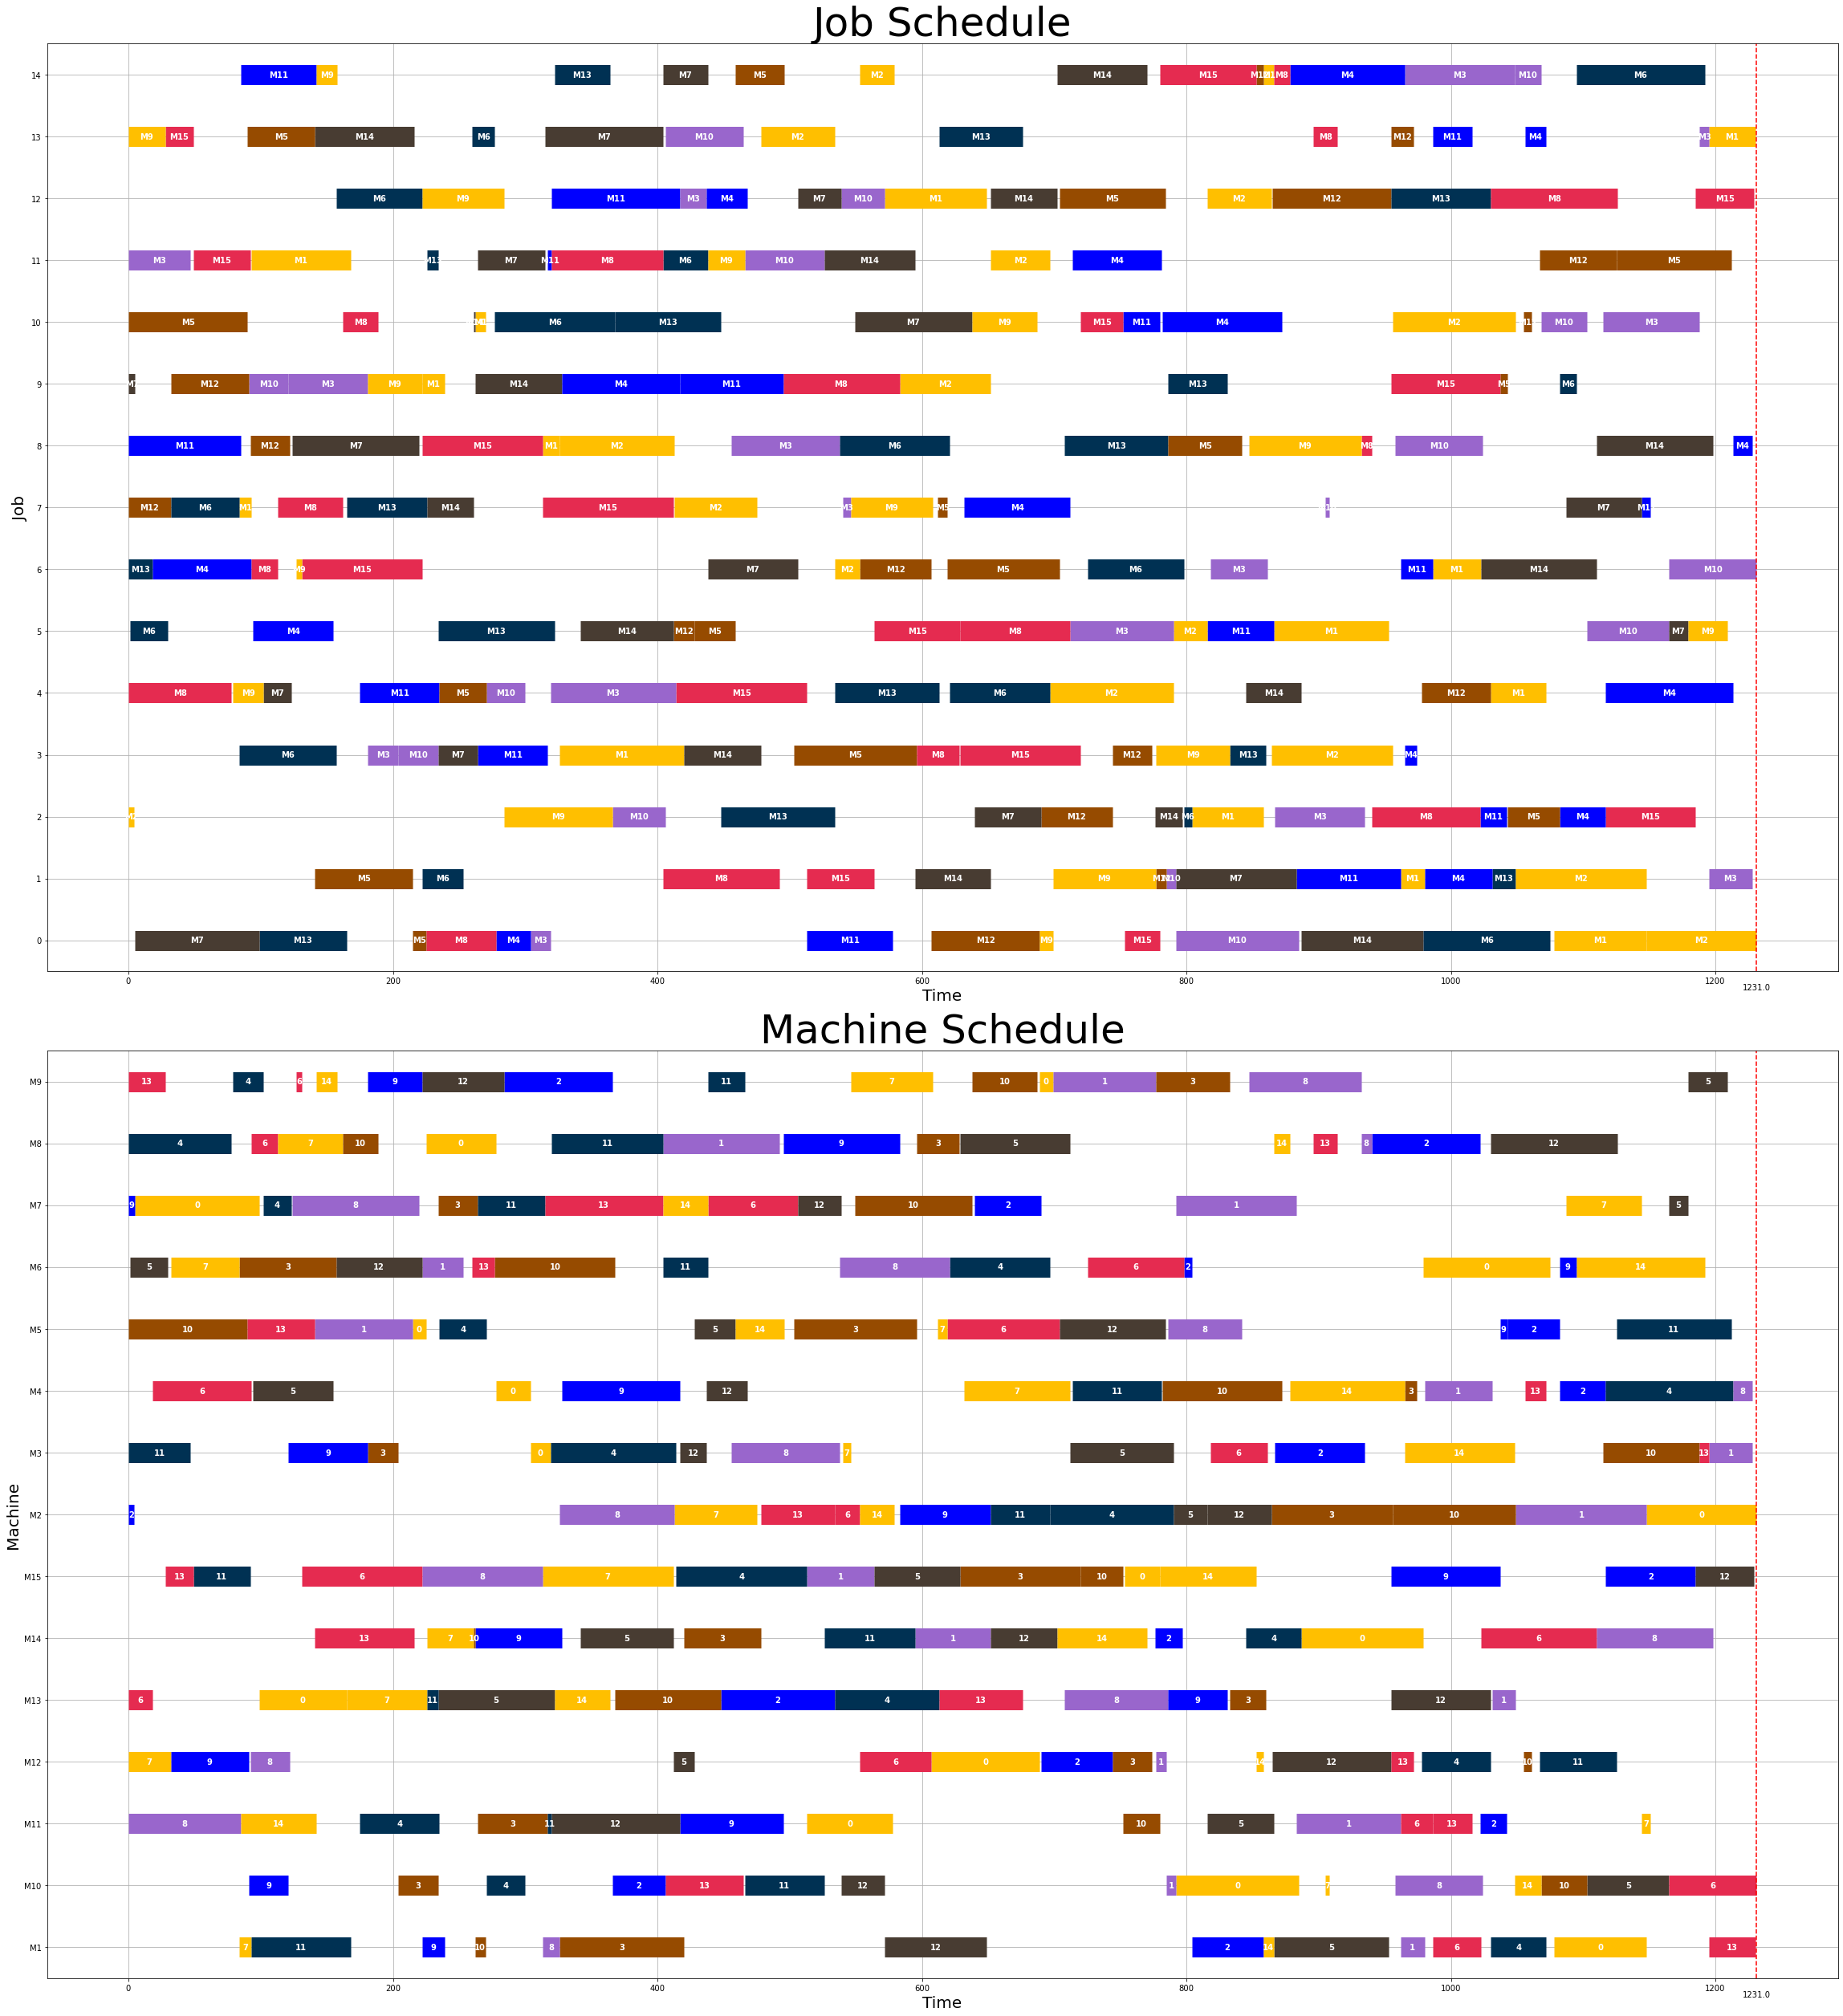

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

def visualize(df):
    
    #schedule = pd.DataFrame(df)
    JOBS = sorted(list(schedule['job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['time'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    #colors = mpl.cm.Dark2.colors
    colors = ['#E52B50', '#FFBF00', '#9966CC', '#0000FF', '#964B00', '#003153', '#483C32',
             '#A7FC00', '#708090', '#CCCCFF', '#800000', '#92000A', '#00A86B', '#7B3F00']
    
    schedule.sort_values(by=['job', 'start'])
    schedule.set_index(['job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(32, 5 + (len(JOBS)+len(MACHINES))))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'start']
                xf = schedule.loc[(j,m), 'time']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule', fontsize=50)
    ax[0].set_ylabel('Job',fontsize=20)
    ax[1].set_title('Machine Schedule',fontsize=50)
    ax[1].set_ylabel('Machine',fontsize=20)
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time',fontsize=20)
        ax[idx].grid(True)
        
    fig.tight_layout()
    plt.savefig("Job Shop Scheduling CP Solution.png")

visualize(df)

## 1.2 - MIP SOLUTION: *Job Shop Scheduling Problem* 

Número de jobs: **15**<br>
Número de máquinas: **15** <br>
Time seed: **840612802**<br>
Machine seed: **398197754**<br>
Upper bound:**1231**<br>
Lower bound: **1005**<br>
<br>http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/jobshop.dir/tai15_15.txt

#### PREPARAÇÃO DE DADOS

In [20]:
from itertools import product
from mip import Model, BINARY

In [21]:
# Splitting machines and times into two separate lists
machines = [[task[0] for task in job] for job in jobs]
times = [[task[1] for task in job] for job in jobs]

In [22]:
times

[[94, 66, 10, 53, 26, 15, 65, 82, 10, 27, 93, 92, 96, 70, 83],
 [74, 31, 88, 51, 57, 78, 8, 7, 91, 79, 18, 51, 18, 99, 33],
 [4, 82, 40, 86, 50, 54, 21, 6, 54, 68, 82, 20, 39, 35, 68],
 [73, 23, 30, 30, 53, 94, 58, 93, 32, 91, 30, 56, 27, 92, 9],
 [78, 23, 21, 60, 36, 29, 95, 99, 79, 76, 93, 42, 52, 42, 96],
 [29, 61, 88, 70, 16, 31, 65, 83, 78, 26, 50, 87, 62, 14, 30],
 [18, 75, 20, 4, 91, 68, 19, 54, 85, 73, 43, 24, 37, 87, 66],
 [32, 52, 9, 49, 61, 35, 99, 62, 6, 62, 7, 80, 3, 57, 7],
 [85, 30, 96, 91, 13, 87, 82, 83, 78, 56, 85, 8, 66, 88, 15],
 [5, 59, 30, 60, 41, 17, 66, 89, 78, 88, 69, 45, 82, 6, 13],
 [90, 27, 1, 8, 91, 80, 89, 49, 32, 28, 90, 93, 6, 35, 73],
 [47, 43, 75, 8, 51, 3, 84, 34, 28, 60, 69, 45, 67, 58, 87],
 [65, 62, 97, 20, 31, 33, 33, 77, 50, 80, 48, 90, 75, 96, 44],
 [28, 21, 51, 75, 17, 89, 59, 56, 63, 18, 17, 30, 16, 7, 35],
 [57, 16, 42, 34, 37, 26, 68, 73, 5, 8, 12, 87, 83, 20, 97]]

In [23]:
machines

[[7, 13, 5, 8, 4, 3, 11, 12, 9, 15, 10, 14, 6, 1, 2],
 [5, 6, 8, 15, 14, 9, 12, 10, 7, 11, 1, 4, 13, 2, 3],
 [2, 9, 10, 13, 7, 12, 14, 6, 1, 3, 8, 11, 5, 4, 15],
 [6, 3, 10, 7, 11, 1, 14, 5, 8, 15, 12, 9, 13, 2, 4],
 [8, 9, 7, 11, 5, 10, 3, 15, 13, 6, 2, 14, 12, 1, 4],
 [6, 4, 13, 14, 12, 5, 15, 8, 3, 2, 11, 1, 10, 7, 9],
 [13, 4, 8, 9, 15, 7, 2, 12, 5, 6, 3, 11, 1, 14, 10],
 [12, 6, 1, 8, 13, 14, 15, 2, 3, 9, 5, 4, 10, 7, 11],
 [11, 12, 7, 15, 1, 2, 3, 6, 13, 5, 9, 8, 10, 14, 4],
 [7, 12, 10, 3, 9, 1, 14, 4, 11, 8, 2, 13, 15, 5, 6],
 [5, 8, 14, 1, 6, 13, 7, 9, 15, 11, 4, 2, 12, 10, 3],
 [3, 15, 1, 13, 7, 11, 8, 6, 9, 10, 14, 2, 4, 12, 5],
 [6, 9, 11, 3, 4, 7, 10, 1, 14, 5, 2, 12, 13, 8, 15],
 [9, 15, 5, 14, 6, 7, 10, 2, 13, 8, 12, 11, 4, 3, 1],
 [11, 9, 13, 7, 5, 2, 14, 15, 12, 1, 8, 4, 3, 10, 6]]

In [24]:
machines = [[i-1 for i in j] for j in machines]

#### MODELO MIP *Job Shop Scheduling Problem* 

In [25]:
# Definição de parâmetros
# n = número de máquinas
# m = número de jobs

n = m = 15

M = sum(times[i][j] for i in range(n) for j in range(m))
M  # Job shop horizon

11671

In [26]:
# # Setup do modelo
# model = Model('JSSP')

# c = model.add_var(name="C")
# x = [[model.add_var(name='x({},{})'.format(j+1, i+1))
#       for i in range(m)] for j in range(n)]
# y = [[[model.add_var(var_type=BINARY, name='y({},{},{})'.format(j+1, k+1, i+1))
#        for i in range(m)] for k in range(n)] for j in range(n)]

# model.objective = c

# for (j, i) in product(range(n), range(1-m)):
#     model += x[j][machines[j][i]] - x[j][machines[j][i-1]] >= times[j][machines[j][i-1]]

# for (j, k) in product(range(n), range(n)):
#     if k != j:
#         for i in range(m):
#             model += x[j][i] - x[k][i] + M*y[j][k][i] >= times[k][i]
#             model += -x[j][i] + x[k][i] - M*y[j][k][i] >= times[j][i] - M

# for j in range(n):
#     model += c - x[j][machines[j][m - 1]] >= times[j][machines[j][m - 1]]

# model.optimize()

# print("Completion time: ", c.x)
# for (j, i) in product(range(n), range(m)):
#     print("task %d starts on machine %d at time %g " % (j+1, i+1, x[j][i].x))

Código acima não foi executado completamente.<br> 
Execução interrompida em 81469.33 segundos, 10 últimos eventos do log a seguir:<br><br>

Cbc0010I After 4218370 nodes, 27032 on tree, 1500 best solution, best possible 1021.0002 (81458.18 seconds)<br>
Cbc0010I After 4218418 nodes, 27037 on tree, 1500 best solution, best possible 1021.0002 (81458.89 seconds)<br>
Cbc0010I After 4218447 nodes, 27064 on tree, 1500 best solution, best possible 1021.0002 (81459.60 seconds)<br>
Cbc0010I After 4218497 nodes, 27062 on tree, 1500 best solution, best possible 1021.0002 (81462.60 seconds)<br>
Cbc0010I After 4218552 nodes, 27044 on tree, 1500 best solution, best possible 1021.0002 (81463.30 seconds)<br>
Cbc0010I After 4218606 nodes, 27031 on tree, 1500 best solution, best possible 1021.0002 (81464.03 seconds)<br>
Cbc0010I After 4218639 nodes, 27060 on tree, 1500 best solution, best possible 1021.0002 (81467.21 seconds)<br>
Cbc0010I After 4218717 nodes, 27012 on tree, 1500 best solution, best possible 1021.0002 (81467.92 seconds)<br>
Cbc0010I After 4218758 nodes, 27053 on tree, 1500 best solution, best possible 1021.0002 (81468.62 seconds)<br>
Cbc0010I After 4218785 nodes, 27080 on tree, 1500 best solution, best possible 1021.0002 (81469.33 seconds)<br>

## 2.1 - CP SOLUTION: *Flow Shop Sequencing Problem*

Número de jobs: **20**<br>
Número de máquinas: **5** <br>
Initial seed: **873654221**<br>
Upper bound:**1278**<br>
Lower bound: **1232**<br>
<br>http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/flowshop.dir/tai20_5.txt

#### MODELO CP *Flow Shop Scheduling Problem* 

In [27]:
from docplex.cp.model import *
import os

filename = 'flowshop_default.data'
with open(filename, 'r') as file:
    NB_JOBS, NB_MACHINES = [int(v) for v in file.readline().split()]
    OP_DURATIONS = [[int(v) for v in file.readline().split()] for i in range(NB_JOBS)]

# Criar modelo
mdl = CpoModel()

# Criar um intervalo por task de cada job
operations = [[interval_var(size=OP_DURATIONS[j][m], name='J{}-M{}'.format(j, m)) for m in range(NB_MACHINES)] for j in range(NB_JOBS)]

# Forçar o início de uma operação após o término da anterior
for j in range(NB_JOBS):
    for m in range(1,NB_MACHINES):
        mdl.add(end_before_start(operations[j][m-1], operations[j][m]))

# Não forçar sobreposição para operações executadas em uma mesma máquina Force no overlap for operations executed on a same machine
for m in range(NB_MACHINES):
    mdl.add(no_overlap(operations[j][m] for j in range(NB_JOBS)))

# Minizar data de término
mdl.add(minimize(max(end_of(operations[i][NB_MACHINES-1]) for i in range(NB_JOBS))))

# Solução do modelo
print('Solving model...')
res = mdl.solve(TimeLimit=10,LogPeriod=1000000)
print('Solution:')
res.print_solution()

Solving model...
 ! --------------------------------------------------- CP Optimizer 20.1.0.1 --
 ! Minimization problem - 105 variables, 85 constraints
 ! TimeLimit            = 10
 ! LogPeriod            = 1000000
 ! Initial process time : 0.05s (0.05s extraction + 0.00s propagation)
 !  . Log search space  : 664.4 (before), 664.4 (after)
 !  . Memory usage      : 681.9 kB (before), 681.9 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        105                 -
 + New bound is 353
 ! Using iterative diving.
 *          1689      201  0.15s        1      (gap is 79.10%)
 *          1520      763  0.15s        1      (gap is 76.78%)
 *          1516     3203  0.15s        1      (gap is 76.72%)
 *          1497     2223  0.15s        3      (gap is 76.42%)
 *          1488     2718  0.15s        3      (gap is 7

#### VISUALIZAÇÃO DOS DADOS

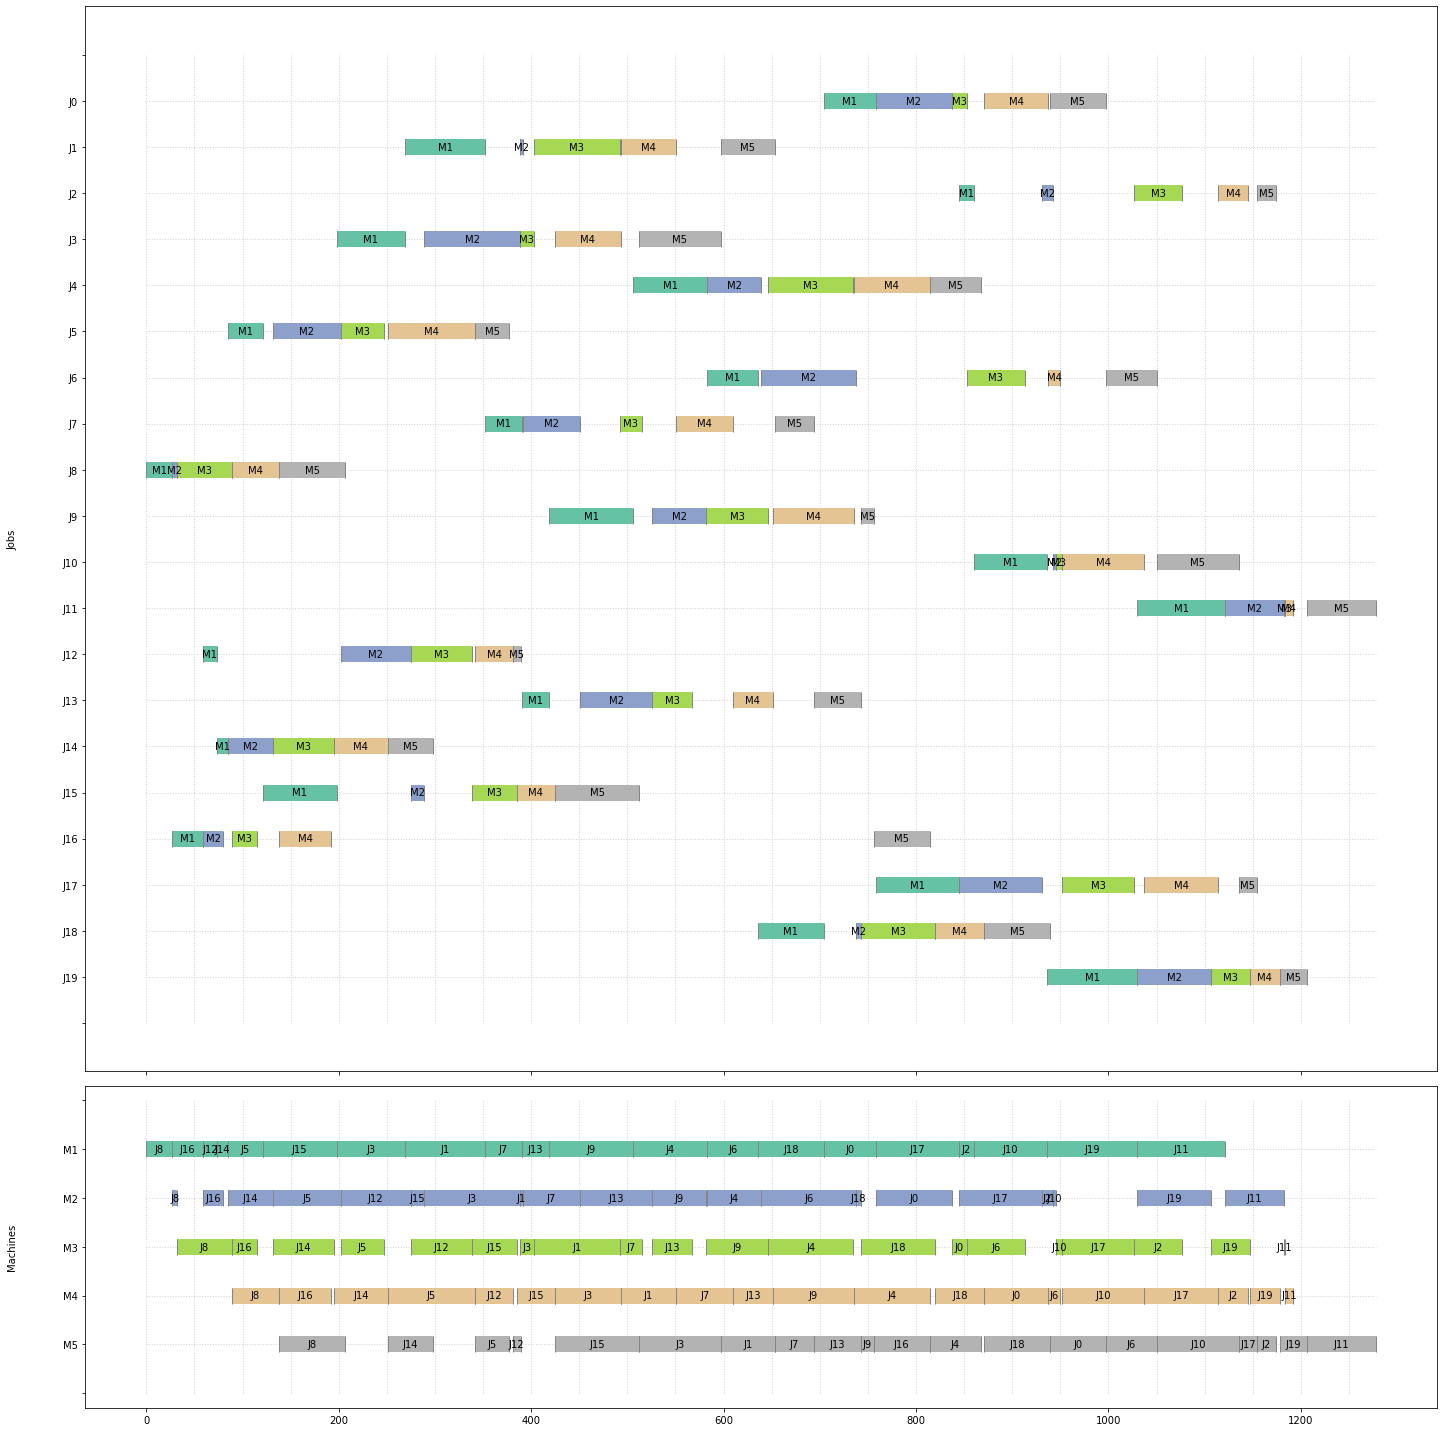

In [28]:
# Display solution
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

if res and visu.is_visu_enabled():
    visu.timeline('Solution for flow-shop ' + filename)
    visu.panel('Jobs')
    for i in range(NB_JOBS):
        visu.sequence(name='J' + str(i),
                      intervals=[(res.get_var_solution(operations[i][j]), j, 'M' + str(j+1)) for j in range(NB_MACHINES)])
    visu.panel('Machines')
    for j in range(NB_MACHINES):
        visu.sequence(name='M' + str(j+1),
                      intervals=[(res.get_var_solution(operations[i][j]), j, 'J' + str(i)) for i in range(NB_JOBS)])
    visu.show(pngfile='Flowshop.png')

## 2.2 - MIP SOLUTION: *Flow Shop Sequencing Problem*

Número de jobs: **20**<br>
Número de máquinas: **5** <br>
Initial seed: **873654221**<br>
Upper bound:**1278**<br>
Lower bound: **1232**<br>
<br>http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/flowshop.dir/tai20_5.txt

 #### BIBLIOTECAS UTILIZADAS

In [29]:
from gurobipy import *
import numpy as np

In [31]:
tasks = [[54, 83, 15, 71, 77, 36, 53, 38, 27, 87, 76, 91, 14, 29, 12, 77, 32, 87, 68, 94],
         [79, 3, 11, 99, 56, 70, 99, 60,  5, 56, 3, 61, 73, 75, 47, 14, 21, 86, 5, 77],
         [16, 89, 49, 15, 89, 45, 60, 23, 57, 64, 7, 1, 63, 41, 63, 47, 26, 75, 77, 40],
         [66, 58, 31, 68, 78, 91, 13, 59, 49, 85, 85, 9, 39, 41, 56, 40, 54, 77, 51, 31],
         [58, 56, 20, 85, 53, 35, 53, 41, 69, 13, 86, 72, 8, 49, 47, 87, 58, 18, 68, 28]]

Tasktime = np.matrix(tasks)

#### MODELO MIP *Job Shop Scheduling Problem* 

In [33]:
# Parameters needed are:
# (1) the total number of jobs (n). Here I denote it by "NumofJobs"
# (2) the total number of machines (m). Here I denote it by "NumofMachines"
# (3) the processing times.  Here I use a numpy matrix: "Tasktime[r, j]" : p_{r,j}

# Based on the matrix Tasktime, we can set:

NumofMachines = Tasktime.shape[0]
NumofJobs = Tasktime.shape[1]

# Construção do modelo:
m = Model ("Wilson")  # Flow Shop Problem proposed by Wilson (1989)


# Variáveis:
z = {}
for j in range(NumofJobs):
    for i in range(NumofJobs):
        z[j, i] = m.addVar(vtype=GRB.BINARY)

s = {}
for r in range(NumofMachines):
    for j in range(NumofJobs):
        s[r, j] = m.addVar(vtype=GRB.CONTINUOUS)

m.update()


# Constraints:
for i in range(NumofJobs):
    m.addConstr(quicksum(z[j, i] for j in range(NumofJobs)) == 1)

for j in range(NumofJobs):
    m.addConstr(quicksum(z[j, i] for i in range(NumofJobs)) == 1)

m.addConstr(s[0, 0] == 0)

for i in range(NumofJobs - 1):
    m.addConstr(s[0, i] + quicksum((Tasktime[0, j]) * z[j, i] for j in range(NumofJobs)) == s[0, i + 1])

for r in range(NumofMachines - 1):
    m.addConstr(s[r, 0] + quicksum((Tasktime[r, j]) * z[j, 0] for j in range(NumofJobs)) == s[r + 1, 0])

for r in range(NumofMachines - 1):
    for i in range(1, NumofJobs):
        m.addConstr(s[r, i] + quicksum(Tasktime[r, j] * z[j, i] for j in range(NumofJobs)) <= s[r + 1, i])

for r in range(1, NumofMachines):
    for i in range(NumofJobs - 1):
        m.addConstr(s[r, i] + quicksum(Tasktime[r, j] * z[j, i] for j in range(NumofJobs)) <= s[r, i + 1])


# Aplicar na função objetivo:
m.setObjective(s[NumofMachines - 1, NumofJobs - 1] + quicksum(Tasktime[NumofMachines - 1, j] * z[j, NumofJobs - 1] for j in range(NumofJobs)), GRB.MINIMIZE)


m.optimize()

Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 216 rows, 500 columns and 4651 nonzeros
Model fingerprint: 0x2b69ee13
Variable types: 100 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3 rows and 3 columns
Presolve time: 0.03s
Presolved: 213 rows, 497 columns, 4021 nonzeros
Variable types: 21 continuous, 476 integer (400 binary)
Found heuristic solution: objective 1490.0000000
Found heuristic solution: objective 1473.0000000

Root relaxation: objective 1.248628e+03, 1009 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I